<a href="https://colab.research.google.com/github/matanb1238/EmotionClassifier/blob/main/notebooks/svm_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Emotion Classification from Tweets
University Machine Learning Project  
**Authors**: [Your Name], [Partner's Name]  
**Dataset**: [Emotions Dataset - Twitter, ~400K rows]  
**Goal**: Understand and classify emotional content in tweets

## Table of Contents
1. [Dataset Overview](#dataset-overview)
2. [Data Cleaning](#data-cleaning)
3. [Exploratory Data Analysis (EDA)](#exploratory-data-analysis)
4. [Feature Extraction: TF-IDF](#feature-extraction)
5. [Model 1: Support Vector Machine (SVM)](#svm)
6. [Model Comparison](#model-comparison)
7. [Conclusion and Discussion](#conclusion)


## 1. Dataset Overview <a name="dataset-overview"></a>

In this section, we load the dataset and explore its basic structure.  
We check column names, sample entries, and class distribution.

In [7]:
import pandas as pd

# File load
df = pd.read_csv('text.csv')

# Checking rows count and the head
print(f"Rows count: {len(df)}")
df.head()

Rows count: 416809


,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


## 2. Data Cleaning <a name="data-cleaning"></a>

We remove missing values and empty texts to prepare the data for analysis.  
This ensures that our models will not be affected by noise or null inputs.

In [8]:
# Check if column names are correct
print("Columns:", df.columns)

# Check for missing values in the dataset
print("Missing values per column:")
print(df.isnull().sum())

# Remove rows with missing values
df = df.dropna()

# Remove empty texts (even if not NaN)
df = df[df['text'].str.strip() != '']

# Show new shape after cleaning
print(f"Dataset shape after cleaning: {df.shape}")

Columns: Index(['Unnamed: 0', 'text', 'label'], dtype='object')
Missing values per column:
Unnamed: 0    0
text          0
label         0
dtype: int64
Dataset shape after cleaning: (416809, 3)


## 3. Exploratory Data Analysis (EDA) <a name="exploratory-data-analysis"></a>

Here we examine:
- Class distribution
- Most common words per emotion
- Confusing emotions
- Tweet length distribution per emotion

We visualize relevant insights using bar charts, box plots, and word clouds.

In [9]:
# Define label-to-emotion mapping based on known dataset structure
label_map = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}

# Create a new column with emotion names instead of numeric labels
df['emotion'] = df['label'].map(label_map)

# Preview the mapping to make sure it worked
print(df[['label', 'emotion']].head())

   label  emotion
0      4     fear
1      0  sadness
2      4     fear
3      0  sadness
4      4     fear


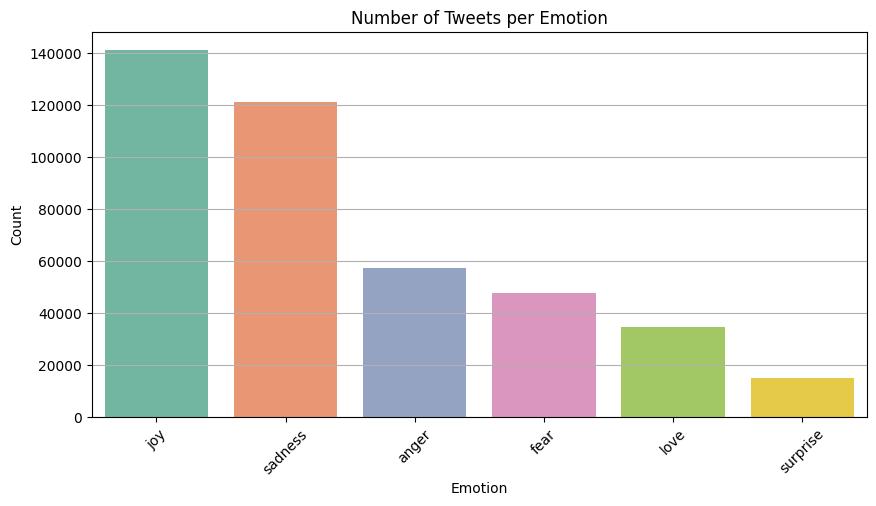

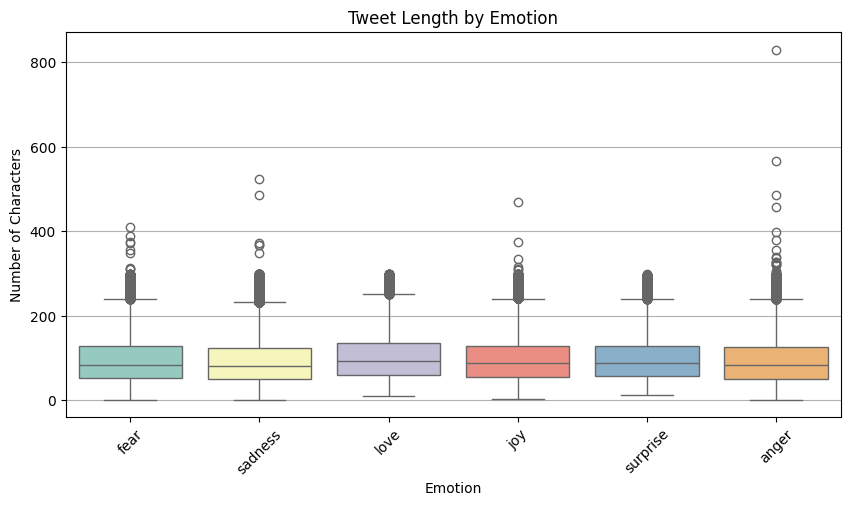

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count the number of examples per emotion
emotion_counts = df['emotion'].value_counts()

# Plot a bar chart of emotion distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values, hue=emotion_counts.index, palette="Set2", legend=False)
plt.title("Number of Tweets per Emotion")
plt.ylabel("Count")
plt.xlabel("Emotion")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Add a new column for text length
df['text_length'] = df['text'].apply(len)

# Plot a boxplot of tweet length per emotion
plt.figure(figsize=(10, 5))
sns.boxplot(x='emotion', y='text_length', data=df, hue='emotion', palette="Set3", legend=False)
plt.title("Tweet Length by Emotion")
plt.ylabel("Number of Characters")
plt.xlabel("Emotion")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


## 4. Feature Extraction: TF-IDF <a name="feature-extraction"></a>

We transform the text into numerical vectors using TF-IDF,  
which captures term importance across the dataset.

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=10000, stop_words='english')

# Fit and transform the text data into a sparse matrix
X = tfidf.fit_transform(df['text'])

# The labels for classification
y = df['emotion']

# Check the shape: (number of tweets, number of words/features)
print(f"TF-IDF matrix shape: {X.shape}")


TF-IDF matrix shape: (416809, 10000)


In [13]:
# Choose a sample tweet (e.g., row 0)
tweet_index = 0

# Get the feature names (words) from the vectorizer
feature_names = tfidf.get_feature_names_out()

# Get the TF-IDF vector for the specific tweet
vector = X[tweet_index]

# Convert the sparse vector to a dense array
dense_vector = vector.toarray().flatten()

# Combine words with their TF-IDF scores
word_scores = list(zip(feature_names, dense_vector))

# Filter only non-zero scores (words that appear in the tweet)
non_zero_scores = [(word, round(score, 3)) for word, score in word_scores if score > 0]

# Sort by TF-IDF score, descending
non_zero_scores = sorted(non_zero_scores, key=lambda x: x[1], reverse=True)

# Print the actual tweet
print("Tweet text:")
print(df.iloc[tweet_index]['text'])

# Print the words and their TF-IDF values
print("\nWords in TF-IDF (non-zero only):")
for word, score in non_zero_scores:
    print(f"{word}: {score}")


Tweet text:
i just feel really helpless and heavy hearted

Words in TF-IDF (non-zero only):
hearted: 0.627
heavy: 0.547
helpless: 0.412
really: 0.266
just: 0.24
feel: 0.098


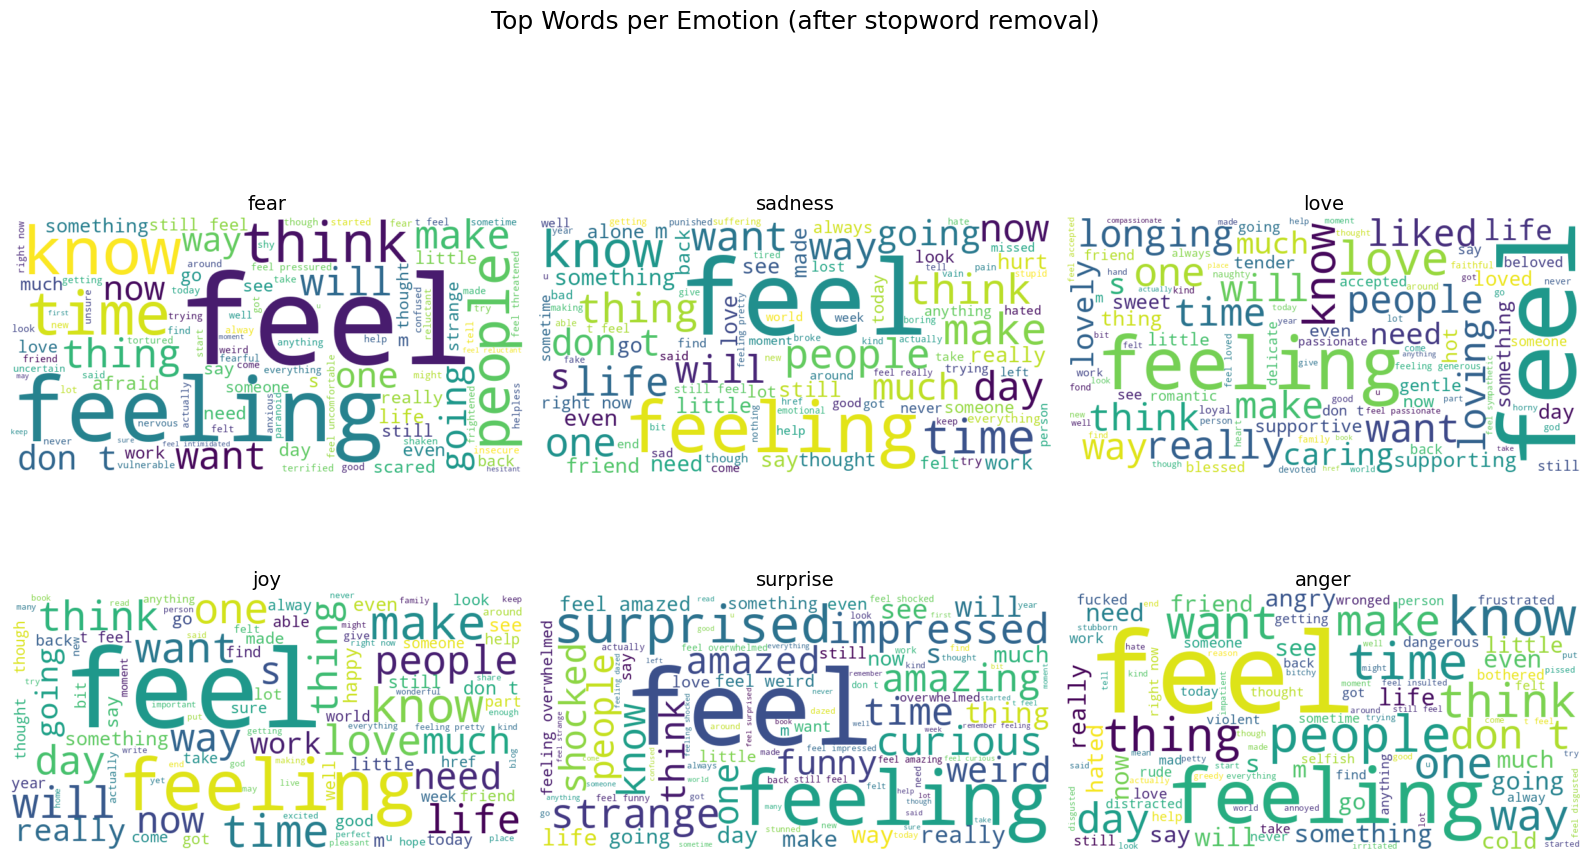

In [17]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Add custom stopwords if needed
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(["im", "dont", "cant", "ive", "youre", "didnt"])  # אפשר להוסיף מילים נפוצות חסרות ערך

emotions = df['emotion'].unique()

plt.figure(figsize=(16, 10))
for i, emotion in enumerate(emotions):
    # Select text of specific emotion
    texts = df[df['emotion'] == emotion]['text']
    text_blob = " ".join(texts)

    # Generate word cloud after removing stopwords
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          stopwords=custom_stopwords,
                          max_words=100).generate(text_blob)

    plt.subplot(2, 3, i + 1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(emotion, fontsize=14)

plt.suptitle("Top Words per Emotion (after stopword removal)", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## 5. Model 1: Support Vector Machine (SVM) <a name="svm"></a>

We train an SVM classifier using the TF-IDF features.  
We evaluate performance using classification metrics and a confusion matrix.

              precision    recall  f1-score   support

       anger       0.90      0.90      0.90     11463
        fear       0.84      0.84      0.84      9542
         joy       0.91      0.92      0.91     28214
        love       0.78      0.76      0.77      6911
     sadness       0.94      0.93      0.93     24238
    surprise       0.72      0.70      0.71      2994

    accuracy                           0.89     83362
   macro avg       0.85      0.84      0.84     83362
weighted avg       0.89      0.89      0.89     83362



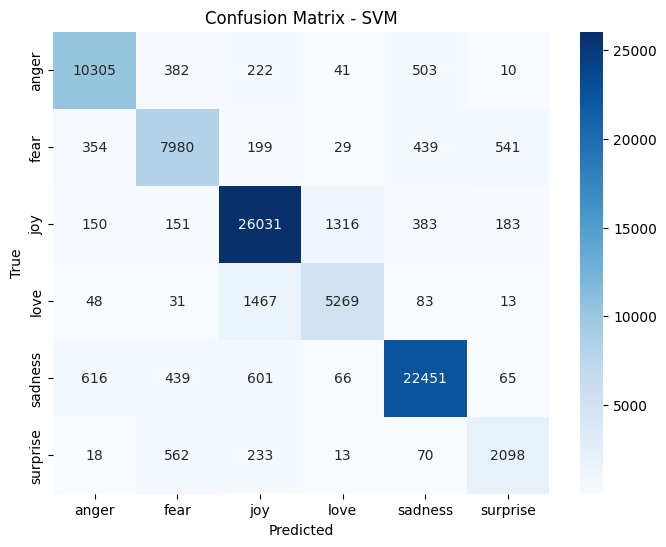

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize and train the SVM model
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)

# Predict on the test set
y_pred = svm_model.predict(X_test)

# Print classification metrics
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=svm_model.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=svm_model.classes_, yticklabels=svm_model.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - SVM')
plt.show()


In [15]:
import random

# Choose random indices from the test set
random_indices = random.sample(range(X_test.shape[0]), 10)

for idx in random_indices:
    true_label = y_test.iloc[idx]
    predicted_label = y_pred[idx]
    text = df.iloc[y_test.index[idx]]['text']

    print("Tweet:", text)
    print(f"True Emotion: {true_label} | Predicted: {predicted_label}")
    print("-" * 80)


Tweet: i don t feel my belly or feel inhibited by it when i work out
True Emotion: fear | Predicted: sadness
--------------------------------------------------------------------------------
Tweet: im feeling really remorseful regretful rawtever for my sins
True Emotion: sadness | Predicted: sadness
--------------------------------------------------------------------------------
Tweet: i feel as if the only association rodarte has had with popular culture are elle fanning and kirsten dunst who are avid fans of the mulleavy sisters work
True Emotion: joy | Predicted: joy
--------------------------------------------------------------------------------
Tweet: i feel heartbroken alittle bit but yeah
True Emotion: sadness | Predicted: sadness
--------------------------------------------------------------------------------
Tweet: i am no pro but being that i have beat and played through the game three times to be exact i feel i can tell you some things i liked and some things i did not
True E

## 6. Model Comparison <a name="model-comparison"></a>

We compare the models using:
- Accuracy
- F1-score (macro & weighted)
- Confusion matrices
- Training time (optional)

## 7. Conclusion and Discussion <a name="conclusion"></a>

We reflect on:
- What worked well
- What didn’t work
- Why some emotions were harder to classify
- Challenges during the project
- Ideas for improvement or future work